# Semi Gradient n-step SARSA

> Luna Lander


In [63]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

## Env

https://gymnasium.farama.org/environments/box2d/lunar_lander/


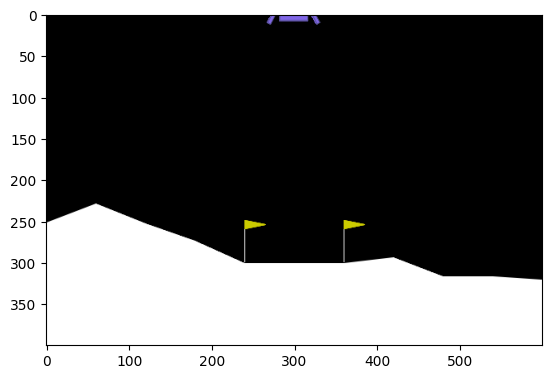

In [64]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# increase episode length from 200 to 4000
env._max_episode_steps = 4000

np.random.seed(13)
env.reset()
plt.imshow(env.render())

In [65]:
state, _ = env.reset()
print(state)

[ 0.00623579  1.4000603   0.63159776 -0.4826752  -0.00721889 -0.14306629
  0.          0.        ]


In [66]:
env.observation_space.high

array([ 2.5      ,  2.5      , 10.       , 10.       ,  6.2831855,
       10.       ,  1.       ,  1.       ], dtype=float32)

In [67]:
print(env.action_space.sample())

3


## Random Action


In [68]:
total_reward = 0.0
total_steps = 0
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)
obs, _ = env.reset()

done = False
while not done:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    total_steps += 1
    done = terminated or truncated
    if total_steps % 200 == 0:
        print(
            f"Step {total_steps:2d}: action={action:2d}, Reward={reward:5.2f}, "
            f"Terminated={terminated}, Truncated={truncated}, info={info}"
        )

print(
    f"Episode finished after {total_steps} steps with total reward: {total_reward:.2f}"
)
env.close()

Episode finished after 122 steps with total reward: -168.68


## Reinforcement Learning


In [69]:
# The implementation of tiles3 is from Richard Sutton's website
# http://incompleteideas.net/tiles/tiles3.html
from tiles3 import IHT, tiles

In [70]:
class QEstimator:
    def __init__(
        self, step_size, num_of_tilings=8, tiles_per_dim=8, max_size=2048, epsilon=0.0
    ):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings
        self.tiles_per_dim = tiles_per_dim
        self.epsilon = epsilon
        self.step_size = step_size / num_of_tilings

        self.table = IHT(max_size)

        self.w = np.zeros(max_size)

        self.env_observation_space_high = env.observation_space.high
        self.env_observation_space_low = env.observation_space.low

        self.pos_x_scale = self.tiles_per_dim / (
            self.env_observation_space_high[0] - self.env_observation_space_low[0]
        )
        self.pos_y_scale = self.tiles_per_dim / (
            self.env_observation_space_high[1] - self.env_observation_space_low[1]
        )
        self.vel_x_scale = self.tiles_per_dim / (
            self.env_observation_space_high[2] - self.env_observation_space_low[2]
        )
        self.vel_y_scale = self.tiles_per_dim / (
            self.env_observation_space_high[3] - self.env_observation_space_low[3]
        )
        self.angle_scale = self.tiles_per_dim / (
            self.env_observation_space_high[4] - self.env_observation_space_low[4]
        )
        self.angle_vel_scale = self.tiles_per_dim / (
            self.env_observation_space_high[5] - self.env_observation_space_low[5]
        )
        self.leg_1_scale = self.tiles_per_dim / (
            self.env_observation_space_high[6] - self.env_observation_space_low[6]
        )
        self.leg_2_scale = self.tiles_per_dim / (
            self.env_observation_space_high[7] - self.env_observation_space_low[7]
        )

    def get_active_features(self, state, action):
        pos_x, pos_y, vel_x, vel_y, angle, angle_vel, leg_1, leg_2 = state
        active_features = tiles(
            self.table,
            self.num_of_tilings,
            [
                self.pos_x_scale * (pos_x - self.env_observation_space_low[0]),
                self.pos_y_scale * (pos_y - self.env_observation_space_low[1]),
                self.vel_x_scale * (vel_x - self.env_observation_space_low[2]),
                self.vel_y_scale * (vel_y - self.env_observation_space_low[3]),
                self.angle_scale * (angle - self.env_observation_space_low[4]),
                self.angle_vel_scale * (angle_vel - self.env_observation_space_low[5]),
                self.leg_1_scale * (leg_1 - self.env_observation_space_low[6]),
                self.leg_2_scale * (leg_2 - self.env_observation_space_low[7]),
            ],
            [action],
        )
        return active_features

    def q_predict(self, state, action):
        active_features = self.get_active_features(state, action)
        return np.sum(self.w[active_features])

    # learn with given state, action and target
    def q_update(self, state, action, target):
        active_features = self.get_active_features(state, action)
        q_s_a = np.sum(self.w[active_features])
        delta = target - q_s_a
        self.w[active_features] += self.step_size * delta

    def get_eps_greedy_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(env.action_space.n)
        else:
            qvals = np.array(
                [self.q_predict(state, action) for action in range(env.action_space.n)]
            )
            return np.argmax(qvals)

In [154]:
def sarsa_n(qhat, env, n=1, gamma=1.0, episode_cnt=10000, max_step_count=300):
    episode_rewards = []
    print_every = max(1, episode_cnt // 10)
    for ec in range(episode_cnt):
        if ec % print_every == 0 or ec == episode_cnt - 1:
            print(f"Episode: {ec + 1}/{episode_cnt}")
        state, _ = env.reset()
        action = qhat.get_eps_greedy_action(state)
        T = float("inf")
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]
        step_count = 0
        while True:
            if t < T:
                next_state, reward, done, _, _ = env.step(action)
                step_count += 1
                states.append(next_state)
                rewards.append(reward)

                # NR: Add max_step_count check becuase sometimes the episode runs for too long.
                if done or step_count > max_step_count:
                    T = t + 1
                else:
                    next_action = qhat.get_eps_greedy_action(next_state)
                    actions.append(next_action)

            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += gamma ** (i - tau - 1) * rewards[i]
                if tau + n < T:
                    G += gamma**n * qhat.q_predict(states[tau + n], actions[tau + n])
                qhat.q_update(states[tau], actions[tau], G)

            if tau == T - 1:
                episode_rewards.append(np.sum(rewards))
                break
            else:
                t += 1
                state = next_state
                action = next_action

    return np.array(episode_rewards)

In [72]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name, np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    # plt.ylim(-500, 0)
    plt.show()

In [147]:
# Create a n-SARSA Learning agent
step_size = 0.2
n = 4
epsilon = 0.01
gamma = 1.0
estimator = QEstimator(step_size, epsilon=epsilon, max_size=10000)
reward_arr = []

[-0.00666685  1.4088272  -0.6752964  -0.09304705  0.00773201  0.15296474
  0.          0.        ]
Episode: 1/100
Episode: 11/100
Episode: 21/100
Episode: 31/100
Episode: 41/100
Episode: 51/100
Episode: 61/100
Episode: 71/100
Episode: 81/100
Episode: 91/100
Episode: 100/100


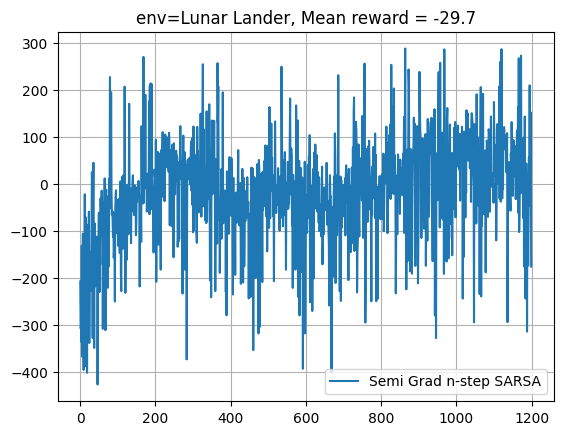

In [160]:
# episode_cnt = 500
episode_cnt = 100

# Initialize environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
state, _ = env.reset(seed=13)
print(state)
rewards = sarsa_n(
    estimator,
    env=env,
    n=n,
    gamma=gamma,
    episode_cnt=episode_cnt,
)
reward_arr = [*reward_arr, *rewards]
# plot rewards
plot_rewards("Lunar Lander", reward_arr, "Semi Grad n-step SARSA")

### Take a look into the agent


In [140]:
state = env.observation_space.sample()
action = env.action_space.sample()
print("=" * 40)
print(f"Sampled state:  {state}")
print(f"Sampled action: {action}")
print("=" * 40)

active_features = estimator.get_active_features(state=state, action=action)
print("Active features for selected state-action pair:")
print(active_features)
print("=" * 40)

q_pred = [estimator.q_predict(state=state, action=a) for a in range(env.action_space.n)]
print("Q-value predictions for all actions:")
for idx, q in enumerate(q_pred):
    print(f"  Action {idx}: {q:.3f}")
print("=" * 40)

a_greedy = estimator.get_eps_greedy_action(state=state)
print(f"Epsilon-greedy action for sampled state: {a_greedy}")
print("=" * 40)

Sampled state:  [-1.124011   -0.33702958  6.8323264   1.7886252  -2.1393132  -4.811379
  0.10329582  0.6081495 ]
Sampled action: 0
Active features for selected state-action pair:
[982, 5065, 8267, 3897, 9692, 1700, 4846, 5513]
Q-value predictions for all actions:
  Action 0: 5.439
  Action 1: -0.855
  Action 2: -18.791
  Action 3: 2.358
Epsilon-greedy action for sampled state: 0


## Take a look at the result


In [163]:
env.close()
env = gym.make("LunarLander-v3", render_mode="rgb_array")
timestamp = int(datetime.datetime.now().timestamp())
timestamp = int(datetime.datetime.now().timestamp())
env = RecordVideo(env=env, video_folder="./video", name_prefix=timestamp)
rewards = sarsa_n(
    estimator,
    env=env,
    n=n,
    gamma=gamma,
    episode_cnt=1,
)
env.close()

Episode: 1/1
